In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix,roc_auc_score,f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import  StratifiedKFold,train_test_split,cross_val_score,RandomizedSearchCV
from imblearn.over_sampling import RandomOverSampler,SMOTE
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras import layers
plt.style.use(['dark_background'])

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
tf.test.gpu_device_name() 

'/device:GPU:0'

In [6]:
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/creditcard.csv')
#Variable Name is not given due to thier privacy reason 
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
df.shape

(284807, 31)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [ ]:
not_fraud=(df['Class'].value_counts()[0]/len(df))*100
fraud=(df['Class'].value_counts()[1]/len(df))*100
print(f'Not Fraud: {not_fraud:.2f}% of dataset')
print(f'Fraud: {fraud:.2f}% of dataset')

Not Fraud: 99.83% of dataset
Fraud: 0.17% of dataset


Text(0.5, 1.0, 'Class Distributions of Frauds(1) and Not frauds(0)')

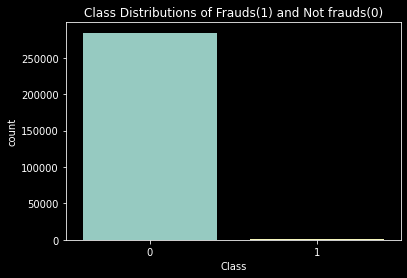

In [ ]:
sns.countplot('Class',data=df)
plt.title('Class Distributions of Frauds(1) and Not frauds(0)')

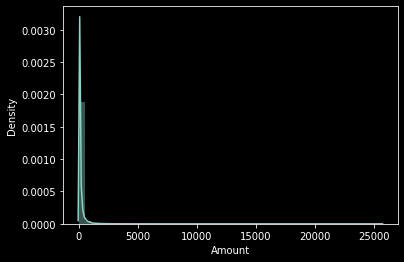

In [ ]:
sns.distplot(df['Amount'])

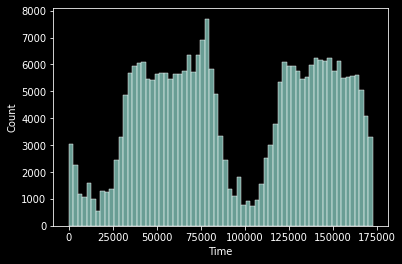

In [ ]:
sns.histplot(df['Time'])

**Scaling Amount and time features**

In [7]:
scaler=StandardScaler()
df['Time']=scaler.fit_transform(df['Time'].values.reshape(-1,1))
df['Amount']=scaler.fit_transform(df['Amount'].values.reshape(-1,1))

**Data Spliting**

In [8]:
x=df.iloc[:,0:30].values
y=df.iloc[:, 30:].values
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)

In [85]:
pd.DataFrame(y_train).value_counts()

0    227465
1       380
dtype: int64

In [86]:
pd.DataFrame(y_test).value_counts()

0    56850
1      112
dtype: int64

# Random OverSampling

In [9]:
OverSampler=RandomOverSampler(sampling_strategy=0.6)
os_x_train,os_y_train=OverSampler.fit_resample(x_train,y_train)

In [87]:
pd.DataFrame(os_y_train).value_counts()

0    227465
1    136479
dtype: int64

# SMOTE(Synthetic Minority Over-sampling Technique)


In [10]:
smote=SMOTE(sampling_strategy=0.6)
sm_x_train,sm_y_train=smote.fit_resample(x_train,y_train)

In [88]:
pd.DataFrame(sm_y_train).value_counts()

0    227465
1    136479
dtype: int64

# Model Building

In [41]:
def model_report(y_test,y_pred):
    print(f'----Confusion matrix---- \n \n{confusion_matrix(y_test,y_pred)}\n')
    print(f'----Accuracy score:{accuracy_score(y_test,y_pred)}\n')
    print(f'Area under curve: {roc_auc_score(y_test,y_pred)}\n')
    print(classification_report(y_test,y_pred))

In [12]:
def cross_validation(estimator,cv=StratifiedKFold(n_splits=10)):
  f1_scores=cross_val_score(estimator,x,y,cv=cv,scoring='f1')
  print(f1_scores)
  print(f'\nAvg F1 Score:{f1_scores.mean()}')

# Random Forest Classfier

**In Orginal Data**

In [89]:
rf_classfier=RandomForestClassifier()
rf_classfier.fit(x_train,y_train)
y_pred=rf_classfier.predict(x_test)
model_report(y_test, y_pred)

----Confusion matrix---- 
 
[[56847     3]
 [   25    87]]

----Accuracy score:0.9995084442259752

Area under curve: 0.8883664719185829

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56850
           1       0.97      0.78      0.86       112

    accuracy                           1.00     56962
   macro avg       0.98      0.89      0.93     56962
weighted avg       1.00      1.00      1.00     56962



In [ ]:
cross_validatiuon(RandomForestClassifier())

array([0.00384228, 0.75229358, 0.79207921, 0.84684685, 0.77419355,
       0.89655172, 0.81904762, 0.80769231])

**With Random OverSampling**

In [91]:
rf_classfier_os=RandomForestClassifier()
rf_classfier_os.fit(os_x_train,os_y_train)
y_pred=rf_classfier_os.predict(x_test)
model_report(y_test, y_pred)

----Confusion matrix---- 
 
[[56846     4]
 [   23    89]]

----Accuracy score:0.9995259997893332

Area under curve: 0.8972862482723961

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56850
           1       0.96      0.79      0.87       112

    accuracy                           1.00     56962
   macro avg       0.98      0.90      0.93     56962
weighted avg       1.00      1.00      1.00     56962



**With SMOTE**

In [92]:
rf_classfier_sm=RandomForestClassifier()
rf_classfier_sm.fit(sm_x_train,sm_y_train)
y_pred=rf_classfier_sm.predict(x_test)
model_report(y_test, y_pred)

----Confusion matrix---- 
 
[[56842     8]
 [   18    94]]

----Accuracy score:0.9995435553526912

Area under curve: 0.9195724965447921

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56850
           1       0.92      0.84      0.88       112

    accuracy                           1.00     56962
   macro avg       0.96      0.92      0.94     56962
weighted avg       1.00      1.00      1.00     56962



# XGBoost Classifier¶

**In Orginal Data**

In [94]:
xgboost=xgb.XGBClassifier(tree_method='gpu_hist',min_child_weight=3,subsample=0.9,
                          max_depth=4,colsample_bytree=0.9)
xgboost.fit(x_train,y_train)
y_pred=xgboost.predict(x_test)
model_report(y_test, y_pred)

----Confusion matrix---- 
 
[[56847     3]
 [   24    88]]

----Accuracy score:0.9995259997893332

Area under curve: 0.8928307576328683

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56850
           1       0.97      0.79      0.87       112

    accuracy                           1.00     56962
   macro avg       0.98      0.89      0.93     56962
weighted avg       1.00      1.00      1.00     56962



In [22]:
cross_validation(xgb.XGBClassifier(tree_method='gpu_hist',gamma=0.1,min_child_weight=3,subsample=0.9,
                          max_depth=4,colsample_bytree=0.9))

[0.67669173 0.54054054 0.93069307 0.81927711 0.80898876 0.72164948
 0.91666667 0.86363636 0.86046512 0.78571429]

Avg F1 Score:0.7924323128481926


**With Random OverSampling**

In [97]:
xgboost_os=xgb.XGBClassifier(tree_method='gpu_hist')
xgboost_os.fit(os_x_train,os_y_train)
y_pred=xgboost_os.predict(x_test)
model_report(y_test, y_pred)

----Confusion matrix---- 
 
[[56670   180]
 [   14    98]]

----Accuracy score:0.9965942207085425

Area under curve: 0.9359168865435357

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56850
           1       0.35      0.88      0.50       112

    accuracy                           1.00     56962
   macro avg       0.68      0.94      0.75     56962
weighted avg       1.00      1.00      1.00     56962



**With SMOTE**

In [98]:
xgboost_sm=xgb.XGBClassifier(tree_method='gpu_hist')
xgboost_sm.fit(sm_x_train,sm_y_train)
y_pred=xgboost_sm.predict(x_test)
model_report(y_test, y_pred)

----Confusion matrix---- 
 
[[56521   329]
 [   13    99]]

----Accuracy score:0.9939959973315544

Area under curve: 0.9390707061188591

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56850
           1       0.23      0.88      0.37       112

    accuracy                           0.99     56962
   macro avg       0.62      0.94      0.68     56962
weighted avg       1.00      0.99      1.00     56962



**Random Forest  performed better than XGBoost!**

<h1>Neural Networks</h1>

In [79]:
model=tf.keras.Sequential([
   layers.Dense(units=64,activation=tf.nn.relu,input_dim=x_train.shape[1]),
   layers.Dense(32,activation=tf.nn.relu),
   layers.Dense(1,activation=tf.nn.sigmoid)
  ])
optimizer=tf.keras.optimizers.Adam(0.0001)
model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['AUC'])

In [80]:
history=model.fit(x_train,y_train,batch_size=128,epochs=25,validation_data=(x_test,y_test))

Epoch 1/25
1781/1781 [==============================] - 7s 4ms/step - loss: 0.0818 - auc: 0.5036 - val_loss: 0.0101 - val_auc: 0.8607
Epoch 2/25
1781/1781 [==============================] - 7s 4ms/step - loss: 0.0066 - auc: 0.8910 - val_loss: 0.0053 - val_auc: 0.9126
Epoch 3/25
1781/1781 [==============================] - 7s 4ms/step - loss: 0.0043 - auc: 0.9230 - val_loss: 0.0040 - val_auc: 0.9357
Epoch 4/25
1781/1781 [==============================] - 7s 4ms/step - loss: 0.0035 - auc: 0.9395 - val_loss: 0.0034 - val_auc: 0.9496
Epoch 5/25
1781/1781 [==============================] - 7s 4ms/step - loss: 0.0031 - auc: 0.9477 - val_loss: 0.0032 - val_auc: 0.9543
Epoch 6/25
1781/1781 [==============================] - 7s 4ms/step - loss: 0.0029 - auc: 0.9505 - val_loss: 0.0031 - val_auc: 0.9500
Epoch 7/25
1781/1781 [==============================] - 7s 4ms/step - loss: 0.0028 - auc: 0.9519 - val_loss: 0.0031 - val_auc: 0.9544
Epoch 8/25
1781/1781 [==============================] - 7s 4ms

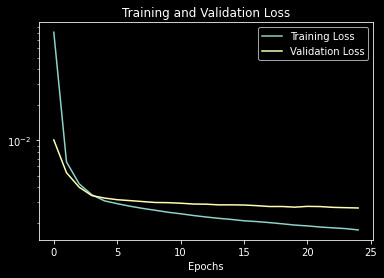

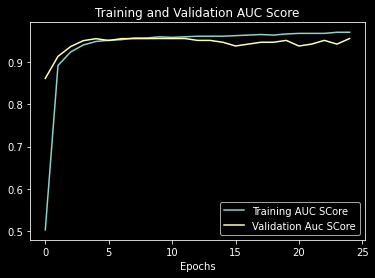

In [84]:
auc=history.history['auc']
val_auc=history.history['val_auc']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(len(loss))

#ploting training and validation loss
plt.plot(epochs,loss,label='Training Loss')
plt.plot(epochs,val_loss,label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.yscale('log')
plt.legend()
plt.show()

#ploting training and validation AUC Score
plt.plot(epochs,auc,label='Training AUC SCore')
plt.plot(epochs,val_auc,label='Validation Auc SCore')
plt.title('Training and Validation AUC Score')
plt.xlabel('Epochs')
# plt.yscale('log')
plt.legend()
plt.show()

In [83]:
y_pred=model.predict_classes(x_test)
model_report(y_test,y_pred)

----Confusion matrix---- 
 
[[56841     9]
 [   21    91]]

----Accuracy score:0.9994733330992591

Area under curve: 0.9061708443271768

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56850
           1       0.91      0.81      0.86       112

    accuracy                           1.00     56962
   macro avg       0.95      0.91      0.93     56962
weighted avg       1.00      1.00      1.00     56962



**Neural Network also performed similar to Random Forest which is not an Improvement!**